<a href="https://colab.research.google.com/github/thaiassiaht/Capacita-Brasil-C-jovem---Ci-ncia-de-Dados/blob/main/modulo-avan%C3%A7ado/Oficina_6_Criando_um_modelo_de_classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O desenvolvimento de modelos preditivos para condições médicas, como o Alzheimer, exige cuidados especiais no tratamento dos dados. O pré-processamento adequado se torna essencial, pois os dados médicos frequentemente apresentam valores ausentes, como em casos de exames não realizados. Além disso, as variáveis podem estar em escalas diferentes, por exemplo, a comparação entre idade e volume cerebral. O balanceamento entre classes também é crucial para evitar viés nos resultados. Para a divisão dos dados, utilizei o padrão de 80/20, separando assim os conjuntos de treino e teste para garantir uma avaliação mais robusta do modelo.

**Pré-processamento**

In [ ]:

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


df = pd.read_csv('alzheimer.csv')
print("Valores ausentes inicialmente:\n", df.isnull().sum())

# Codificar variáveis categóricas de forma segura
df['M/F'] = df['M/F'].map({'M': 0, 'F': 1, 'Male': 0, 'Female': 1}).fillna(-1)  # Preenche valores inesperados
df['Group'] = df['Group'].map({'Nondemented': 0, 'Demented': 1, 'Control': 0, 'Patient': 1}).fillna(-1)


df = df[df['Group'] != -1]

# Tratar valores ausentes - abordagem moderna sem warning
df = df.assign(SES=df['SES'].fillna(df['SES'].median()))

# Verificar valores infinitos
print("\nValores infinitos após tratamento:")
print(df.select_dtypes(include=np.number).apply(lambda x: np.isinf(x).sum()))

X = df.drop(['Group'], axis=1)
y = df['Group']

# Pipeline completo com verificação
try:
    pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler(),
        RandomForestClassifier(n_estimators=150, random_state=42)
    )

except Exception as e:
    print("\nErro durante o processamento:", e)
    print("\nDicas para solução:")
    print("1. Verifique se há valores NaN no target (y)")
    print("2. Inspecione os tipos de dados com df.dtypes")
    print("3. Verifique valores inesperados nas colunas categóricas")

Valores ausentes inicialmente:
 Group     0
M/F       0
Age       0
EDUC      0
SES      19
MMSE      2
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64

Valores infinitos após tratamento:
Group    0
M/F      0
Age      0
EDUC     0
SES      0
MMSE     0
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64


Divisão do conjunto de dados

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Group', axis=1)
y = df['Group']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

Treinamento do modelo

In [ ]:
rf = RandomForestClassifier(n_estimators=150,
                           max_depth=8,
                           min_samples_split=5,
                           random_state=42)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]  # Probabilidades para AUC-ROC


Avaliação do modelo

In [ ]:
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

Acurácia: 1.0

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        38
         1.0       1.00      1.00      1.00        30

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68

AUC-ROC: 1.0


Ajuste de hiperparâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc'
)
grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Melhores parâmetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


Validação cruzada

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    best_rf,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy'
)
print(f"Acurácia Média (CV): {scores.mean():.2f} (±{scores.std():.2f})")

Acurácia Média (CV): 0.99 (±0.01)


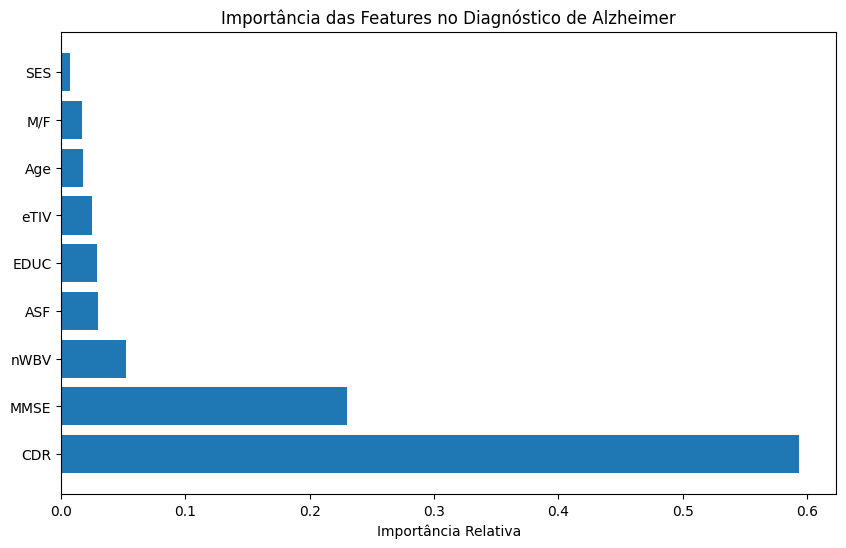

In [ ]:
import matplotlib.pyplot as plt

#importância das features
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Importância das Features no Diagnóstico de Alzheimer')
plt.xlabel('Importância Relativa')
plt.show()


Para evitar o overfitting em um modelo, é importante monitorar a diferença entre o desempenho no conjunto de treinamento e no conjunto de teste. Uma estratégia eficaz para isso é a utilização de técnicas de regularização, como ajustar o max_depth e o min_samples_split. Além disso, a validação cruzada deve ser empregada para garantir que o modelo mantenha um bom desempenho em dados não vistos, ajudando a identificar se ele está se adaptando demais aos dados de treinamento